# Basic text classification

This notebook demonstrates multi-class text classification starting from plain text files stored on disk. A multi-class classifier is trained to predict the tag for a programming question on Stack Overflow.


In [252]:
import matplotlib.pyplot as plt
import os
import re
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [253]:
print(tf.__version__)

2.9.2


## Sentiment analysis

This notebook trains a sentiment analysis model to classify StackOverflow questions based on the programming language tag, based on the text of the review. This is an example of multi-class—classification, an important and widely applicable kind of machine learning problem.

The dataset used is the [StackOverflow](https://ai.stanford.edu/~amaas/data/sentiment/) dataset prepared by Google that contains the text of 16,000 StackOverflow questions from the much larger [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) dataset, which contains more than 17 million posts. These are split into 8,000 reviews for training and 8,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of questions from each class.


### Download and explore the StackOverflow dataset

Let's download and extract the dataset, then explore the directory structure.

In [254]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

train_dataset_dir = os.path.join(os.path.dirname(dataset), 'train')
test_dataset_dir = os.path.join(os.path.dirname(dataset), 'test')

In [255]:
os.listdir(train_dataset_dir)

['java', 'csharp', 'python', 'javascript']

In [256]:
os.listdir(test_dataset_dir)

['java', 'csharp', 'python', 'javascript']

The `/train` and `/test` directories contain many text files, each of which is a single question. Let's take a look at one of them.

In [257]:
sample_file = os.path.join(train_dataset_dir, 'java/1.txt')
with open(sample_file) as f:
  print(f.read())

"add version to @@webservice i'm using blankx.jws.webservice to create my webservice, in addition to targetnamespace i would like to include a ""version"" attribute to mark the version of my service. what other tag can i use in addition to this one to accomplish this so my wdsl will look like:..&lt;schema targetnamespace=""http://example.com/2009/02/15/webservice"" version=""1.1"" xmlns=""http://www.w3.org/2000/10/xmlschema&gt;...i.e. it has a version attribute"



### Load the dataset

Next, the data must be loaded off disk and prepared into a format suitable for training. To do so, the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility will be used, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
...class_c/
......c_text_1.txt
......c_text_2.txt
...class_d/
......d_text_1.txt
......d_text_2.txt
.
.
.

```

The `text_dataset_from_directory` utility is used to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

Next, we divide the dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The StackOverflow dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [258]:
batch_size = 32
seed = 101

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


There are 8,000 questions in the training folder, we will use 80% (or 6,400) for training. The model can be trained by passing a dataset directly to `model.fit`. 

Some questions contain raw text (with punctuation and occasional HTML tags like `<br/>`). This will be handled in the following section. 

The labels are 0, 1, 2, 3, which correspond to 'csharp', 'java', 'javascript', 'python', respectively, as verified below.


In [259]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


The remaining 1,600 questions from the training set will be used for validation.

Note:  When using the `validation_split` and `subset` arguments, a random seed must be specified, or `shuffle=False` passed as an argument, so that the validation and training splits have no overlap.

In [260]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [261]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


### Prepare the dataset for training

Next, the data must be standardized, tokenized, and vectorized using the helpful `tf.keras.layers.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens. Vectorization refers to converting tokens into numbers to be fed into a neural network. All of these tasks can be accomplished with this layer.

As mentioned previously, some questions may contain various HTML tags like `<br />`, which will not be removed by the default standardizer in the `TextVectorization` layer. A custom standardization function to remove the HTML tags must be defined and passed as the 'standardize' argument to the vectorization layer.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside the model when deployed, as shown further down in the notebook.

In [262]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

When creating the `TextVectorization` layer to standardize, tokenize, and vectorize our data, the `output_mode` will be set to `int` to create unique integer indices for each token.

Note: when using the default split function, and the custom standardization function defined above, some constants for the model must be defined. For example, an explicit maximum `sequence_length`, which will cause the layer to extend or truncate the sequenced questions to exactly `sequence_length` values.
Another constant that must be defined is `max_features`, this specifies the maximum number of words that will be included in the total vocabulary of the model.

In [263]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, `adapt` will be called to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use the training data when calling adapt (using the test set would leak information to the model).

In [264]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

A function to see the result of using this layer to preprocess some data is needed.

In [265]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [266]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question", first_question)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized question", vectorize_text(first_question, first_label))

Question tf.Tensor(b'"type mismatch : cannot convert from element type object to string i have a dropdown list that i want to fill via a database.i show  code  ..private string mavaleur; .private list&lt;selectitem&gt; meselements;..            public string getmavaleur() {.                return mavaleur;.            }.            public void setmavaleur(string mavaleur) {.                this.mavaleur = mavaleur;.            }.            public list getmaliste().            {.                arraylist&lt;string&gt; unelist = new arraylist();..                try { .                    class.forname(""com.mysql.jdbc.driver"").newinstance(); .                     string servername = ""localhost"";.                        string mydatabase = ""gestionticket"";.                        string url = ""jdbc:mysql://"" + servername +"":3306""+ ""/""+ mydatabase; // a jdbc url.                         string user = ""root"";.                         string pass = """";...                    

Tokens are replaced by integers. By calling `.get_vocabulary()` on the layer, the word corresponding to a specific token can be displayed.

In [267]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  con
 313 --->  order
Vocabulary size: 10000


TextVectorization is now applied to each dataset.

In [268]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods that can be used when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training the model.

`.prefetch()` overlaps data preprocessing and model execution while training. 

More information about both methods, as well as how to cache data to disk can be found at [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [269]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the neural network:

In [270]:
embedding_dim = 16

In [271]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.5),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.5),
  layers.Dense(4, activation='softmax')])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_16 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_8   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_______________________________________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded questions and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  More about embeddings: [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings).
2. A `GlobalAveragePooling1D` layer gives a fixed-length output vector for each question by averaging over the sequence dimension, allowing the model to handle inputs of variable length.
3. The fixed-length output vector is piped through a dense layer with 16 hidden nodes. 
4. The last layer is densely connected with 4 output nodes, one for each class.

### Loss function and optimizer

Since this is a multi-class-classification problem and the model outputs probabilities (a four-node-layer with a SoftMax activation function), the `losses.SparseCategoricalCrossentropy` loss function is used.

In [272]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])



### Train the model

In [273]:
epochs = 40
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback])

Epoch 1/40
200/200 [==============================] - 3s 12ms/step - loss: 1.3813 - accuracy: 0.3034 - val_loss: 1.3760 - val_accuracy: 0.4100
Epoch 2/40
200/200 [==============================] - 1s 4ms/step - loss: 1.3633 - accuracy: 0.4087 - val_loss: 1.3544 - val_accuracy: 0.4631
Epoch 3/40
200/200 [==============================] - 1s 4ms/step - loss: 1.3331 - accuracy: 0.4636 - val_loss: 1.3173 - val_accuracy: 0.4931
Epoch 4/40
200/200 [==============================] - 1s 4ms/step - loss: 1.2877 - accuracy: 0.5267 - val_loss: 1.2681 - val_accuracy: 0.5312
Epoch 5/40
200/200 [==============================] - 1s 4ms/step - loss: 1.2327 - accuracy: 0.5678 - val_loss: 1.2112 - val_accuracy: 0.5556
Epoch 6/40
200/200 [==============================] - 1s 4ms/step - loss: 1.1740 - accuracy: 0.5869 - val_loss: 1.1519 - val_accuracy: 0.5944
Epoch 7/40
200/200 [==============================] - 1s 4ms/step - loss: 1.1198 - accuracy: 0.6191 - val_loss: 1.0955 - val_accuracy: 0.6169
Epoch

### Evaluate the model

To see how the model performs, two values will be returned, loss and accuracy.

In [274]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 2s 8ms/step - loss: 0.5653 - accuracy: 0.7971
Loss:  0.565345287322998
Accuracy:  0.797124981880188


### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [275]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation, used to plot the training and validation loss for comparison, as well as the training and validation accuracy.

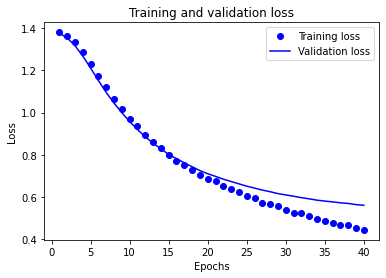

In [276]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

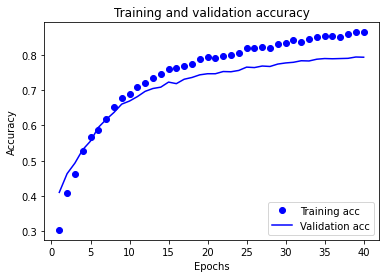

In [277]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

To prevent overfitting, `tf.keras.callbacks.EarlyStopping` callback was used.

## Export the model

In the code above, `TextVectorization` was applied to the dataset before feeding text to the model. To make the model capable of processing raw strings, the `TextVectorization` layer can be included inside the model, as mentioned earlier in the notebook.

In [278]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 2s 9ms/step - loss: 1.0229 - accuracy: 0.7971
0.797124981880188


### Inference on new data

Call `model.predict()` to get model predictions

In [279]:
examples = [
  "how to dynamic print() def function",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 105ms/step


array([[0.213118  , 0.21026985, 0.24377336, 0.33283874],
       [0.2501551 , 0.24777105, 0.26674488, 0.23532899],
       [0.24968378, 0.24331206, 0.27226436, 0.23473977]], dtype=float32)

Including the text preprocessing logic inside the model enables exportation of a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply the TextVectorization layer. Using it outside the model enables asynchronous CPU processing and buffering of data when training on GPU. When training a model on GPU, this option can be used to get the best performance while developing the model, then the TextVectorization layer can be included inside the model when it's ready for deployment.

See this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) for more information about saving models.